# Imports

In [ ]:
!pip install scikit-plot
!pip install beautifulsoup4
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/LargeMovieReviewDataset.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from wordcloud import WordCloud
from keras.callbacks import ModelCheckpoint
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from keras import Sequential
import os
import re
import json
import zipfile
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, GlobalMaxPool1D, Bidirectional, GRU
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup
import gensim
from matplotlib import pyplot
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import warnings
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
cachedStopWords = stopwords.words("english")

# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# Functions

In [ ]:
# Function for for fitting the model and getting predictions
def classifier_f(clf, X_train, y_train, X_test):                             
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    return y_pred, probs

In [ ]:
# Function for plotting wordcloud
def plot_wordcloud(coef, feature_names_list, top_features=100):               
    coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    feature_names = np.array(feature_names_list)
    
    fig = plt.figure(figsize=(13, 15), tight_layout=True)
       
    for i, features in enumerate(zip([top_positive_coefficients, top_negative_coefficients], ['Top 50 positive bigrams \n', 'Top 50 negative bigrams \n'])):
        ax = fig.add_subplot(2,1,i+1)
        tags = feature_names[features[0]]
        for idx, tag in enumerate(tags):
            tags[idx] = tag.replace(' ', '_')
        ax.imshow(WordCloud(max_words=50, background_color="white", width=1100, height=500,colormap='coolwarm').generate(' '.join(tags)), interpolation='bilinear', alpha=0.9)
        ax.set_title(features[1], fontsize=25)
        ax.axis('off')

In [ ]:
# Function for plotting history metrics
def plot_metrics(hist, metric1, metric2):
  x = range(1, len(history.history['accuracy']) + 1)
  pyplot.subplot(211)
  pyplot.title(f'{metric1}')
  pyplot.plot(hist.history[f'{metric1}'], label='train')
  pyplot.plot(hist.history[f'val_{metric1}'], label='val')
  pyplot.legend()

  pyplot.subplot(212)
  pyplot.title(f'{metric2}')
  pyplot.plot(hist.history[f'{metric2}'], label='train')
  pyplot.plot(hist.history[f'val_{metric2}'], label='val')
  pyplot.legend()
  pyplot.show()

In [ ]:
# Function for classification report and confusion matrix
def report(y_test, y_pred):
    print('\n====classification report:====')
    print(classification_report(y_test, y_pred))

    print('\n====confusion matrix====')
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)

# Data description and reading

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

* We have dataset for binary sentiment classification. 
* We provide a set of 50,000 highly polar movie reviews for training and testing.
* There are no missing values in the dataset
* Target is sentiment variable which has positive or negative value
* Dependent variable is review feature which is text in English

In [ ]:
# Reading dataset
data = pd.read_csv('LargeMovieReviewDataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Checking for duplicates
data.duplicated().sum()

418

In [ ]:
# Deleting duplicates
data = data.drop_duplicates()

# EDA

## Target

Text(0.5, 1.0, 'Sentiment distribution')

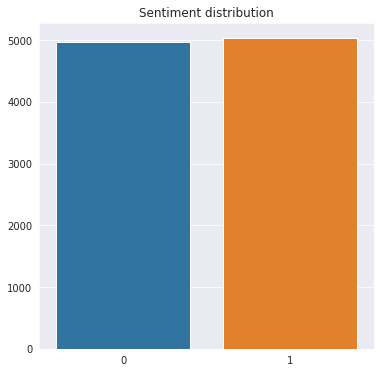

In [ ]:
# Visualizing target variable Sentiment distribution
sns.barplot(data.sentiment.value_counts().index, data.sentiment.value_counts().values)
plt.title("Sentiment distribution")

We can see that our dataset is almost perfectly balanced and we have nearly the same amount of records for negative and positive reviews

## Statistics for review feature

In [ ]:
# Adding some statistics about X feature 'review' 
stats = pd.DataFrame()
stats['review_len'] = data['review'].astype(str).apply(len)
stats['word_count'] = data['review'].apply(lambda x: len(str(x).split()))
stats['spaces'] = stats['word_count']-1
stats['avg_word_len'] = (stats['review_len']-stats['spaces']) / stats['word_count']
stats.head()

,review_len,word_count,spaces,avg_word_len
0,1761,307,306,4.739414
1,998,162,161,5.166667
2,926,166,165,4.584337
3,748,138,137,4.427536
4,1317,230,229,4.730435


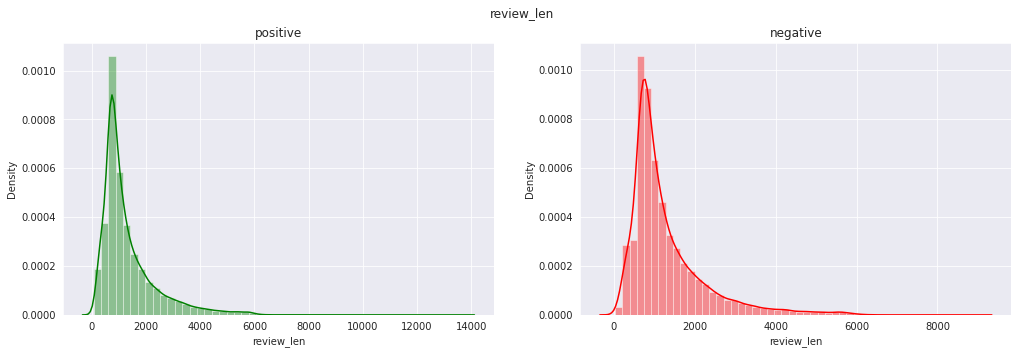

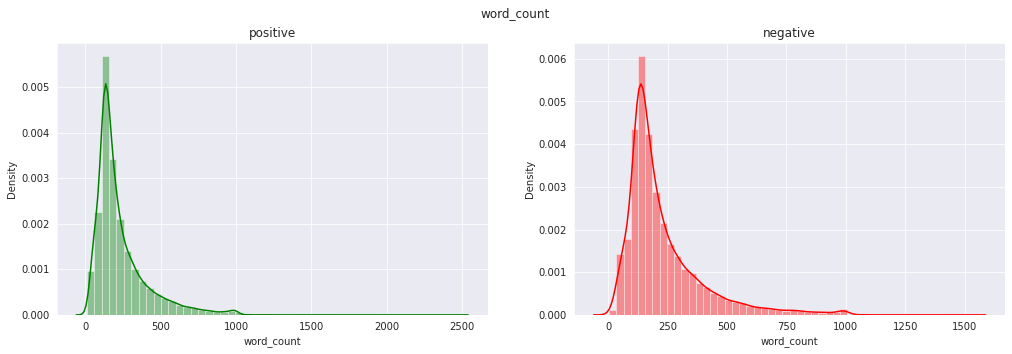

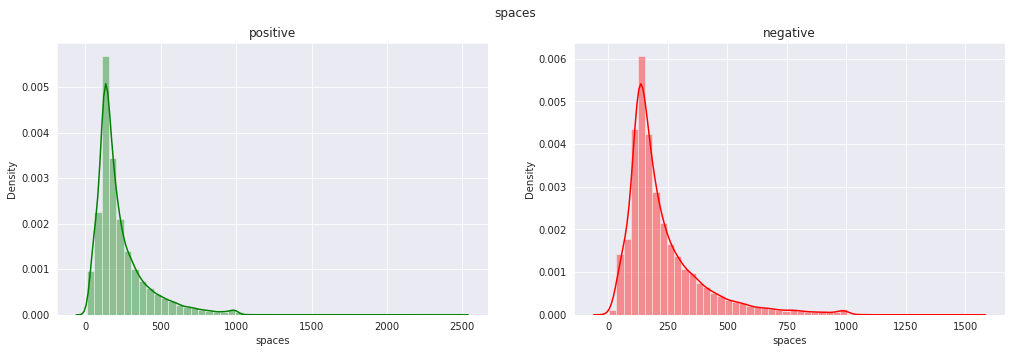

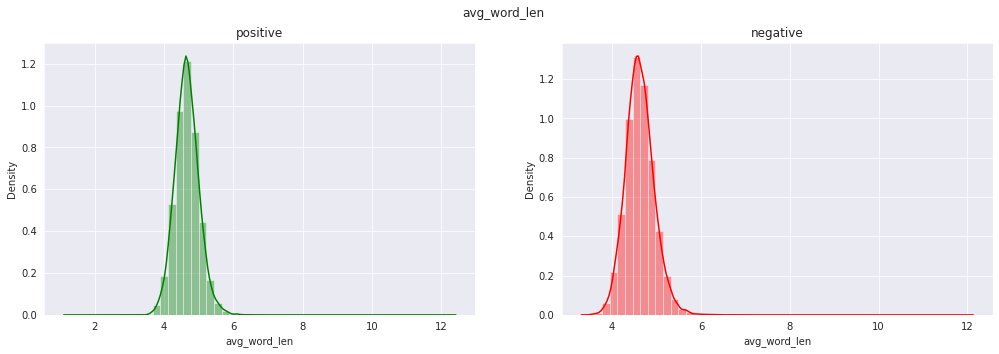

In [ ]:
# Visualizion for every statistical column distribution for positive and negative sentiment
for stat in stats.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(17,5))
    sns.distplot(stats[data.sentiment == 'positive'][stat], ax=ax1, color='green')
    ax1.set_title('positive')
    sns.distplot(stats[data.sentiment == 'negative'][stat], ax=ax2, color='red')
    ax2.set_title('negative')
    fig.suptitle(stat)

* Distribution for negative and positive review are almost the same from analyzed statistics point of view, which means that target doesn't depend on review length or subjectivity
* From some statistical metrics we can see that review length is very different for dataset, but mainly it is more then 700 symbols or 125 words
* Average word length is mainly in range 4-5 words
* All statistics have outliers

# Preprocessing

In [ ]:
# Encoding classes
vals_to_replace = {'negative': 0, 'positive':'1'}
data.sentiment = data.sentiment.map(vals_to_replace).astype(int)

In [ ]:
# Words with apostrophe
ap_words = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"im" :"I am",
"isn't" : "is not",
"its": "it is",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"won't":"will not",
"didn't": "did not"
}

In [ ]:
# Removing/adding some words to stopwords
cachedStopWords.remove('not') # can be useful in sentiment analysis
cachedStopWords.append('one') # just digits which were noticed while reading the data
cachedStopWords.append('two') # just digits which were noticed while reading the data

In [ ]:
# Creating instance for stemming 
stemmer = SnowballStemmer(language='english')

In [ ]:
# Function for replacing words with apostrophes
def replace_ap(sen):
    for i, j in ap_words.items():
      sen = sen.replace(i, j)
    return sen
    
# Function for total text preprocessing
def preproc(text):
  tokens = []
  sen_cleaned = []

  # Cleaning and tokenization
  for sen in text:
    fil = []
    # sen = i
    sen = replace_ap(sen) # replacing apostrophes
    soup = BeautifulSoup(sen, "html.parser")  
    sen = soup.get_text(separator=" ") # cleaning from html tags
    sen = sen.lower() # changing to lower case
    sen = re.sub(r'\d+', '', sen) # cleaning from digits
    sen = re.sub(r'[^\w\s]', '', sen) # cleaning from punctuation
    wd = nltk.word_tokenize(sen) # tokenization
    wd = [w for w in wd if not w in cachedStopWords] # removing stopwords
    # Normalisation: stemming
    for word in wd:
      fil.append(stemmer.stem(word))

    tokens.append(fil)
    fil_joined =' '.join(word for word in fil)
    sen_cleaned.append(fil_joined)
  return tokens, sen_cleaned

In [ ]:
# Function for TF-IDF transformation
def tf_idf(docs):
    tfidf = TfidfVectorizer(min_df=10, max_features=5000,
                        use_idf=True, sublinear_tf=True,
                        ngram_range=(2,2))
    tfidf.fit(docs)
    return tfidf

Here only part of data was taken for future models as on Colab I was facing 2 types of issues: 
* limited GPU by Colab, sometimes access was not available
* RAM crashing for big amount of data

So just to be able to compare models in Colab and have outputs I did analysis on smaller amount of data, but it didn't change a lot the scores if to compare relatively.

In [ ]:
data = data.head(10000)

In [ ]:
# Preprocessing the review data
tk, tx = preproc(data.review)

In [ ]:
# Adding preprocessed data to dataframe
data['tokens'] = tk
data['sen_cleaned'] = tx
data.head()

,review,sentiment,tokens,sen_cleaned
0,One of the other reviewers has mentioned that ...,1,"[review, mention, watch, oz, episod, hook, rig...",review mention watch oz episod hook right exac...
1,A wonderful little production. <br /><br />The...,1,"[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,1,"[thought, wonder, way, spend, ti, ame, hot, su...",thought wonder way spend ti ame hot summer wee...
3,Basically there's a family where a little boy ...,0,"[basic, famili, littl, boy, jake, think, zombi...",basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[petter, mattei, love, ti, ame, money, visual,...",petter mattei love ti ame money visual stun fi...


In [ ]:
# Splitting into test and train sets
train_x, test_x, train_y, test_y = train_test_split(data.sen_cleaned, data.sentiment, test_size = 0.20, shuffle=True, stratify=data.sentiment)

In [ ]:
# TF-IDF vectorization for train and test
vectorizer = tf_idf(train_x)
vectorised_train = vectorizer.transform(train_x)
vectorised_test = vectorizer.transform(test_x)

# LinearSVC as Baseline

* As a baseline LinearSVC model was selected as it was the optimal one during Classification module
* As a metric **accuracy** can be used as we have perfectly balanced data and both positive and negative reviews are important
* Also classification report and confusion matrix will be checked to get more general overview on model evaluation

In [ ]:
# In order to get a probability prediction, wrap LinearSVC in CalibratedClassifierCV
svc = CalibratedClassifierCV(LinearSVC(random_state=42))
y_pred, y_probs = classifier_f(svc, vectorised_train, train_y, vectorised_test)


====classification report:====
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       994
           1       0.78      0.81      0.80      1006

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000


====confusion matrix====


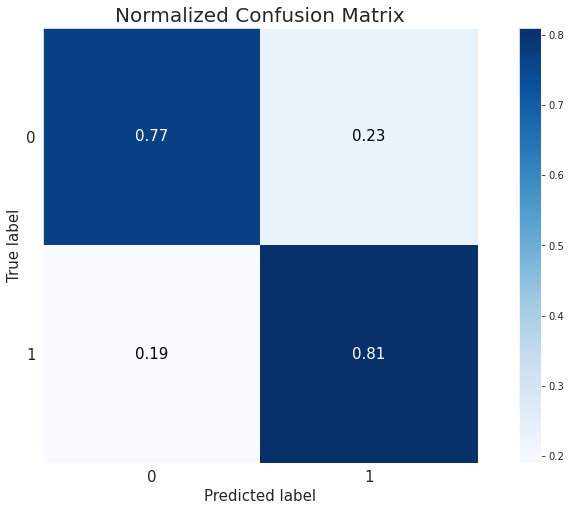

In [ ]:
# Classification report and confusion matrix
report(test_y, y_pred)

As we can see all metrics are around 80% wich is pretty good due to that we took smaller amount of data then it was in Classification task. That was done because of limited RAM in Google colab when was working with RNN. Anyway main goal is to compare two approaches.

In [ ]:
# creating lists for comparing models in the end
scores = [0.79]
models = ['LinearSVC', 'LTSM', 'BiLTSM', 'BiLTSM_hyp', 'Glove', 'Word2Vec', 'GRU']

In [ ]:
# Coeficcients for SVC model
coefs = 0
for i in svc.calibrated_classifiers_:
    coefs = coefs + i.base_estimator.coef_
coefs = coefs/len(svc.calibrated_classifiers_)

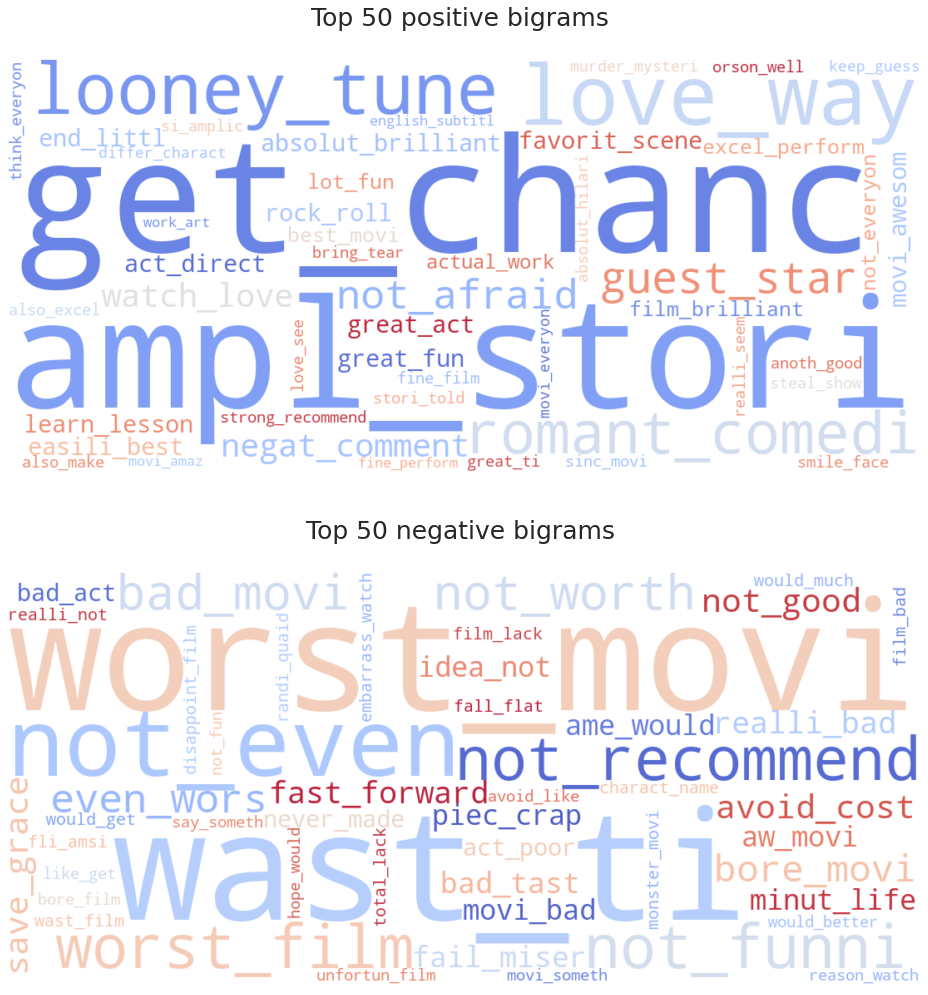

In [ ]:
# Plotting wordcloud
plot_wordcloud(coefs, vectorizer.get_feature_names())

Some main words used for distinguishing positive and negative reviews are visualized on wordclouds

# RNN models

## LTSM

First will check what is min and max review length in our dataset

In [ ]:
print('Maximum review length: {}'.format(
len(max((data.sen_cleaned), key=len))))
print('Minimum review length: {}'.format(
len(min((data.sen_cleaned), key=len))))

Maximum review length: 5736
Minimum review length: 46


And now let's prepare the data before fitting to RNN model

In [ ]:
# Instantiating tokenizer and some parameters
tn = Tokenizer(num_words=5000)
max_words = 2000
# max_words = 2000
embedding_dim = 50

In [ ]:
# Fitting tokenizer with train data and setitting total vocabulary size
tn.fit_on_texts(train_x)
word_index = tn.word_index
vocab_size = len(tn.word_index) + 1

In [ ]:
# Transforming review from text to numerical sequences and adding padding
tr_seq = tn.texts_to_sequences(train_x)
train_x = pad_sequences(tr_seq, padding='post', truncating='post', maxlen=max_words)
ts_seq = tn.texts_to_sequences(test_x)
test_x = pad_sequences(ts_seq, padding='post', truncating='post', maxlen=max_words)

In [ ]:
# Creating basic LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=max_words))
model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Printing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 50)          2133100   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,200,029
Trainable params: 2,200,029
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 500
num_epochs = 50

# Splitting into validation and train sets
train_x2, val_x, train_y2, val_y = train_test_split(train_x, train_y, test_size = 0.20, shuffle=True, stratify=train_y)

# Training the model
history = model.fit(train_x2, train_y2, validation_data=(val_x, val_y), batch_size=batch_size, epochs=num_epochs)


====classification report:====
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       994
           1       0.50      1.00      0.67      1006

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.34      2000


====confusion matrix====


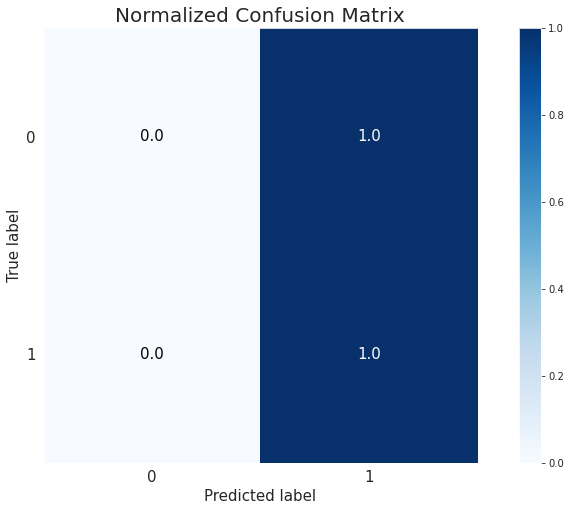

In [ ]:
# Checking the metrics and confusion matrix
y_pred = model.predict_classes(test_x)
report(test_y, y_pred)

As we can see metrics are not very good, they are much worth then for baseline model, so will try to improve it with some other approaches. The reason can be that we have pretty small amount of data for training and LTSM model takes into account only information of the past, not future direction.

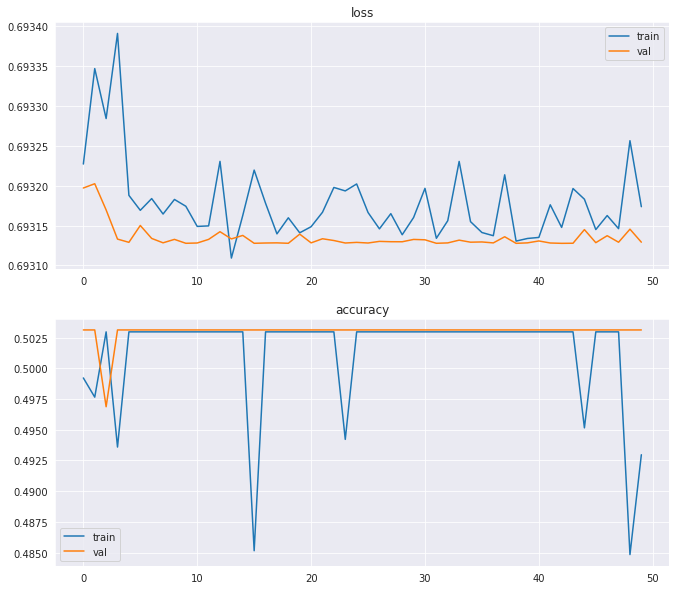

In [ ]:
# Plotting metric's history while training
plot_metrics(history, 'loss', 'accuracy')

As we can see on 15 epoch loss stopped decreasing so actually we could stop training at that moment, for accuracy even earlier.
In next models will be used Early Stopping and save best model's checkpoints for future use.


## Early Stopping / Model Checkpoint

To avoid not needed training when loss function stops decreasing EarlyStopping instance will be used. Also we can save best model's results with ModelCheckpoint instance. Both of them will be added to callbacks and will be used for future models.

In [ ]:
#Adding early stopping with monitoring validation loss
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3) 

In [ ]:
# Adding model checkpoint with monitoring validation loss
filepath = "model_weights/best_model.hdf5" 
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
# Creating list of callbacks - early stopping and model checkpoint
callbacks_list = [early_stop, model_checkpoint]

## Bidirectional LTSM

Now let's try to improve our metrics with Bidirectional LSTM

In [ ]:
# Creating Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_words))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Printing model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 50)          2142350   
_________________________________________________________________
bidirectional (Bidirectional (None, 2000, 128)         58880     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,246,671
Trainable params: 2,246,671
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model, callbacks are used now
history = model.fit(train_x2, train_y2, validation_data=(val_x, val_y), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list)


====classification report:====
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       994
           1       0.81      0.88      0.84      1006

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000


====confusion matrix====


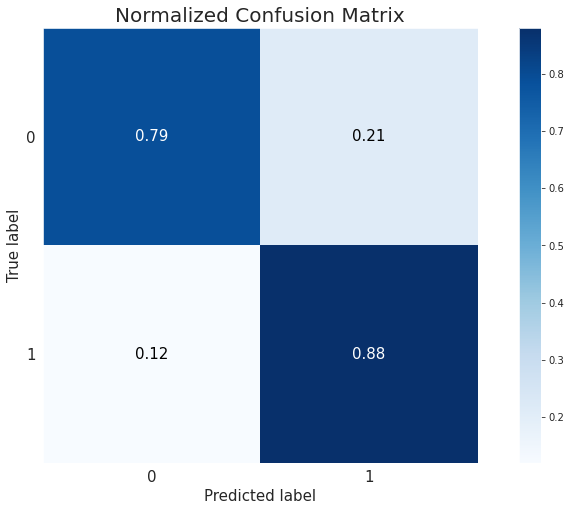

In [ ]:
# Checking the metrics and confusion matrix
y_pred = model.predict_classes(test_x)
report(test_y, y_pred)

As we can see now our metrics show much better results and it is better then baseline model as well. 

In [ ]:
# Checking accuracy for test data
score = model.evaluate(test_x, test_y, verbose=1)
scores.append(score[1]) 
print('Test accuracy:', score[1])

63/63 [==============================] - 7s 118ms/step - loss: 0.5269 - accuracy: 0.8320
Test accuracy: 0.8320000171661377


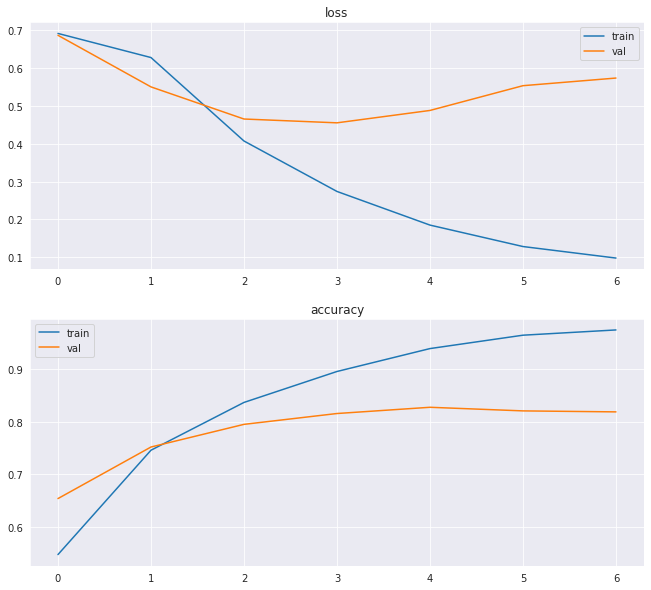

In [ ]:
# Plotting metric's history while training
plot_metrics(history, 'loss', 'accuracy')

And thanks to early stopping we can see that training stopped when loss stopped decreasing for validation dataset

We can say that Bidirectional model gave much better result, 0.83 for accuracy, I and II type of errors are pretty small, and only 6 epochs was enough to get this level of accuracy. Bidirectional model is better because it take into account data in both past and future direction.

## Hyperparameters tuning

Now let's try to improve our model with some hyperparameters tuning. Only some basics hyperparameters were checked due to limited memory on Colab

In [ ]:
# Function for creating base model 
def create_model(num_filters, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Bidirectional(LSTM(num_filters, return_sequences=True)))
    model.add(Bidirectional(LSTM(num_filters)))
    model.add(Dense(num_filters, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[max_words])
model = KerasClassifier(build_fn=create_model,
                        epochs=4, batch_size=500,
                        verbose=1)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=3, verbose=1)
# randomized grid search
grid_result = grid.fit(train_x2, train_y2)

In [ ]:
# Evaluate model with best hyperparameters on testing set
test_accuracy = grid.score(test_x, test_y)
scores.append(test_accuracy) 

4/4 [==============================] - 2s 305ms/step - loss: 0.4116 - accuracy: 0.8370


In [ ]:
# Checking best parameters values
grid_result.best_params_

{'embedding_dim': 50, 'maxlen': 2000, 'num_filters': 64, 'vocab_size': 42567}

4/4 [==============================] - 2s 300ms/step

====classification report:====
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       994
           1       0.85      0.82      0.84      1006

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000


====confusion matrix====


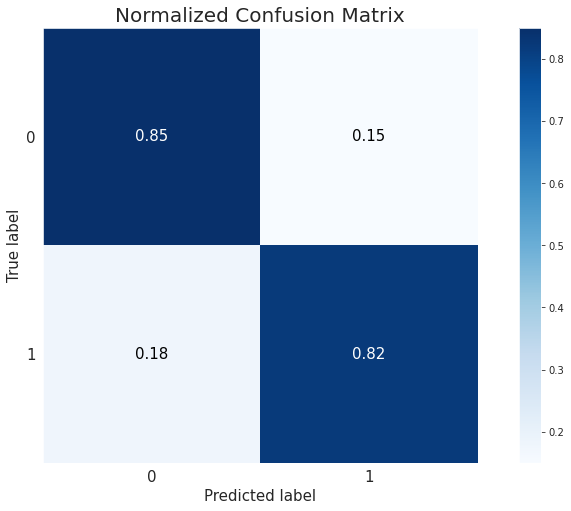

In [ ]:
# Checking the metrics and confusion matrix
y_pred = grid_result.predict(test_x)
report(test_y, y_pred)

And as we can see now we have improved accuracy score, it is 0.84 which is maximum in this notebook

## Pretrained GloVe model

As pretrained model I've selected GloVe as it worked the most stable for me in Colab. 

In [ ]:
# Function for creating embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
# Creating embedding matrix
embedding_matrix = create_embedding_matrix('gdrive/MyDrive/glove.6B.50d.txt', tn.word_index, embedding_dim)

First let's check model with GloVe without additional training (trainable = False)

In [ ]:
# Creating the model with pretrained weights
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_words, 
                           trainable=False))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Printing model's summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 50)          2117450   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,120,779
Trainable params: 3,329
Non-trainable params: 2,117,450
_________________________________________________________________


In [ ]:
# Fitting the model
history = model.fit(train_x2, train_y2, validation_data=(val_x, val_y), batch_size=batch_size, epochs=num_epochs, callbacks=[callbacks_list])

In [ ]:
# Checking accuracy for train and test set
loss, accuracy = model.evaluate(train_x, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_x, test_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6273
Testing Accuracy:  0.6175


We can see that score is better then for Baseline LTSM model but still not so good as in previous section


====classification report:====
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       994
           1       0.59      0.76      0.67      1006

    accuracy                           0.62      2000
   macro avg       0.63      0.62      0.61      2000
weighted avg       0.63      0.62      0.61      2000


====confusion matrix====


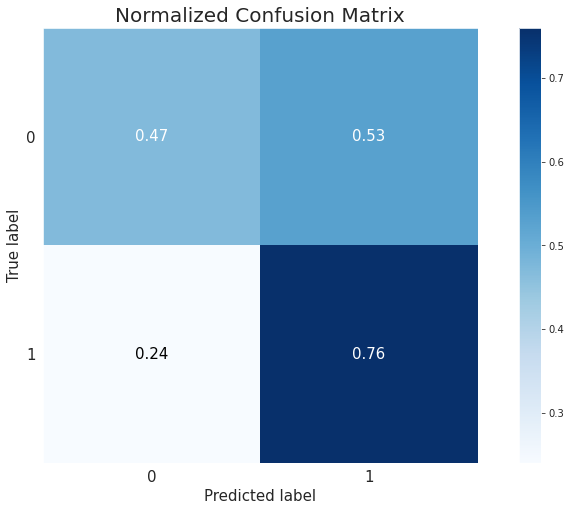

In [ ]:
# Checking the metrics and confusion matrix
y_pred = model.predict_classes(test_x)
report(test_y, y_pred)

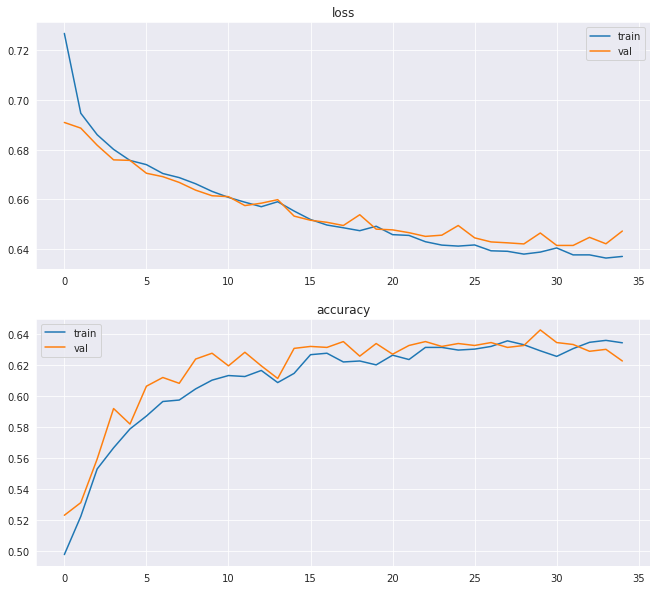

In [ ]:
# Plotting history
plot_metrics(history, 'loss', 'accuracy')

To get the highest accuracy and lowest loss we needed 27-30 epochs.

Now let's see how GloVe performs if we allow the embedding to be trained by using trainable=True

In [ ]:
# Model's architecture
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_words, 
                           trainable=True))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting the model
history = model.fit(train_x2, train_y2, validation_data=(val_x, val_y), batch_size=batch_size, epochs=50, callbacks=[callbacks_list])


====classification report:====
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       994
           1       0.79      0.78      0.79      1006

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000


====confusion matrix====


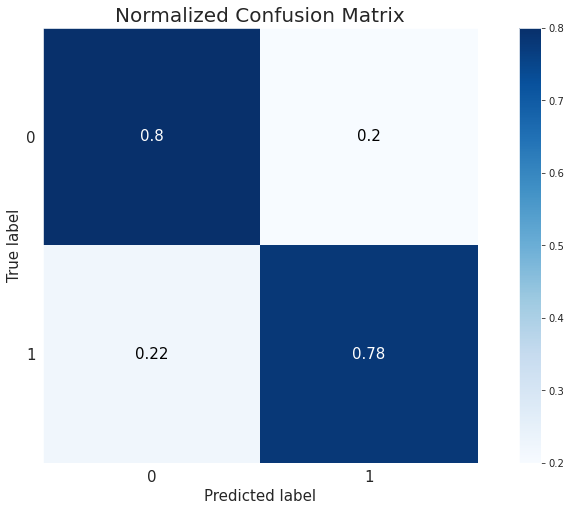

In [ ]:
# Checking the metrics and confusion matrix
y_pred = model.predict_classes(test_x)
report(test_y, y_pred)

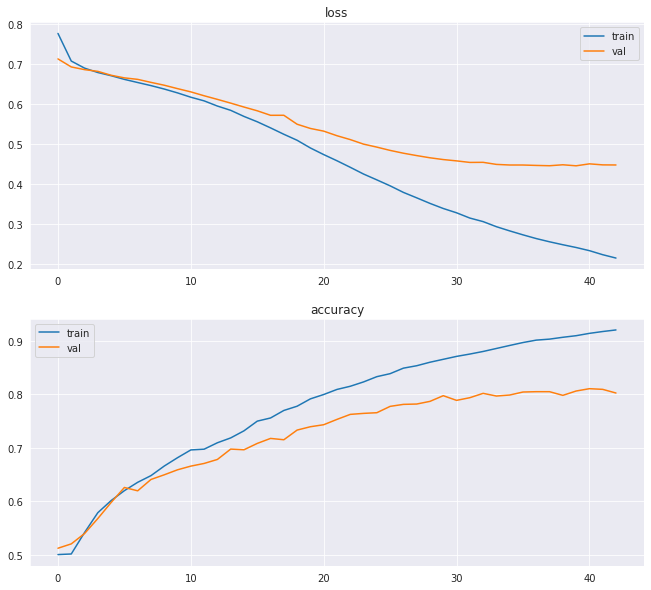

In [ ]:
# Plotting history
plot_metrics(history, 'loss', 'accuracy')

In [ ]:
# Checking accuracy for train and test set
loss, accuracy = model.evaluate(train_x, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_x, test_y, verbose=False)
scores.append(accuracy) 
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8997
Testing Accuracy:  0.7890


Now we can see that result is really improved and accuracy become very close to Bidirectional one.

## Pretrained Word2Vec model

In [ ]:
# Function for getting max length
def get_max_length(df):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in df['review']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

# max_length for the input length in the model
max_length = get_max_length(data)

In [ ]:
# Load pre-trained Word2Vec model
emb = gensim.models.KeyedVectors.load_word2vec_format('gdrive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# Creating embedding matrix
skipped_words = 0
embedding_dim = 300
emb_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tn.word_index.items():
  try:
    emb_vector = emb[word]
  except:
    skipped_words = skipped_words+1
  if emb_vector is not None:
    emb_matrix[index] = emb_vector

print('Embedding matrix shape : ', emb_matrix.shape)

Embedding matrix shape :  (42717, 300)


In [ ]:
# Creating the model
emb_layer = Embedding(vocab_size, embedding_dim, weights=[emb_matrix], input_length=max_length, trainable=True)
model = Sequential()
model.add(emb_layer)
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Printing model's summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1830, 300)         12815100  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,908,605
Trainable params: 12,908,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model
history = model.fit(train_x2, train_y2, validation_data=(val_x, val_y), batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list)

In [ ]:
# Checking accuracy for test data
score = model.evaluate(test_x, test_y, verbose=1)
scores.append(score[1]) 
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 19ms/step - loss: 0.6921 - accuracy: 0.5071
Test accuracy: 0.5071302652359009


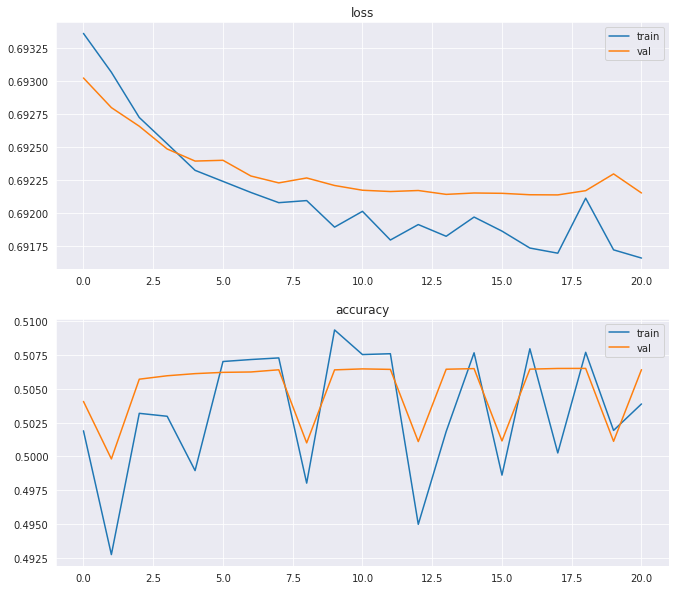

In [ ]:
# Plotting metric's history while training
plot_metrics(history, 'loss', 'accuracy')

For pretrained Word2Vec I've got bad score, may be this pretrained embedding was not very good for this dataset

## GRU

Also I've tried to build GRU model 

In [ ]:
# Preparing train and validation data for GRU model
train_x2 = np.array(train_x2)
train_x2 = np.reshape(train_x2, (train_x2.shape[0],train_x2.shape[1],1))
val_x = np.array(val_x)
val_x = np.reshape(val_x, (val_x.shape[0],val_x.shape[1],1))

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(train_x2.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(train_x.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))

# Compiling the GRU model
regressorGRU.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

# Fitting to the training set
history = regressorGRU.fit(train_x2, train_y2, validation_data=(val_x, val_y), batch_size=batch_size, epochs=num_epochs, callbacks=[callbacks_list])

In [ ]:
# Checking accuracy for test data
test_x = np.array(test_x)
test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))
score = regressorGRU.evaluate(test_x, test_y, verbose=1)
scores.append(score[1]) 
print('Test accuracy:', score[1])

63/63 [==============================] - 21s 338ms/step - loss: 7.7587 - accuracy: 0.4970
Test accuracy: 0.4970000088214874


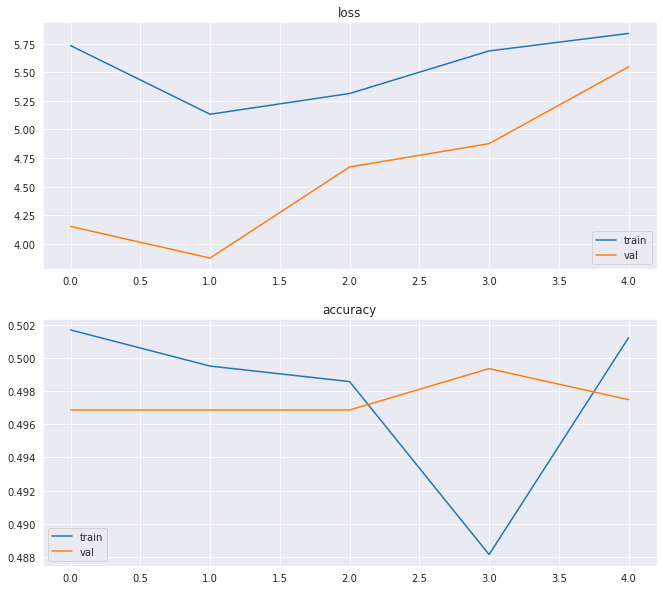

In [ ]:
# Plotting metric's history while training
plot_metrics(history, 'loss', 'accuracy')


====classification report:====
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       994
           1       0.00      0.00      0.00      1006

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000


====confusion matrix====


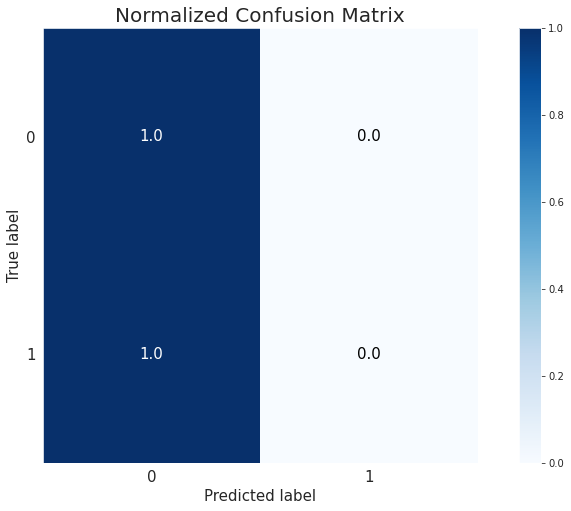

In [ ]:
# Checking the metrics and confusion matrix
y_pred = regressorGRU.predict_classes(test_x)
report(test_y, y_pred)

Unfortunatelly this model also didn't gave any good score for this dataset.

# Summary

In [ ]:
summary = pd.DataFrame(scores, models)
summary

,0
LinearSVC,0.79
LTSM,0.50
BiLTSM,0.83
BiLTSM_hyp,0.84
Glove,0.79
Word2Vec,0.51
GRU,0.50


* As we can see from the summary the best model is Bidirectional LTSM after hyperparameters tuning
* Also from pretrained models GloVe gave the best result
* And LinearSVC also gave us good result and it is fast and simple model if to compare to RNN models, which means that NN are not always the best one choice for such tasks as this one.
